In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
"""
CONSTANTES:
"""
Tc = 631 #K Esta es la temperatura crítica del niquel. Se escogió este elemento, ya que nos permite tomar datos por encima de la temperatura crítica, pero por debajo de la temperatura de fusión

In [3]:
def calcular_energia_y_m(conf):
    """
    Esta función determina la energía de una configuracion de spines dada en la matriz conf, la cual es una matriz de -1 y 1's que representa los spines.
    Para ello, primero determina el producto de los espines vecinos horizontalmente y guarda esos productos en una matriz llamada "enlaces_horizontales". 
    Para hallar esta matriz, simplemete creamos una matriz confH la cual es conf con su primera columna corrida hasta el final, es decir, la primera columna de conf es la última de confH, 
    la segunda columna de conf es la primera de confH, la tercera de conf es la segunda de confH y así sucesivamente. Finalmente multiplicamos cada uno de los elementos de conf y confH
    Luego, hallamos la matriz de los productos verticales, la cual llamamos "enlaces_verticales". Para hallar esta matriz se sigue un procedimiento similar lo que se hizo con "enlaces_horizontales" 
    aquí se crea una matriz llamada confV que es conf, pero con la primera fila colocada de último. 
    Finalmente se suman todos los valoes de enlaces_horizontales y enlaces_verticales y se multiplica por -1, para obtener E/J

    La función también determina la magnetización sumando todos los elementos de la matriz conf y luego dividiendo sobre el número de elementos de esa matriz 
    
    @input <np.array> conf: Matriz llena de valores con -1 y 1 que representa la configuración de espines a la cual se determinará la energía
    @input <float> J: Parámetro J que está en la formula del hamiltoniano
    @output <dict>: {m <float>: magnetización, e/J <int>: energía de la configuracion dividida entre J}
    """
    n_lado = len(conf[:,0])
    #confH no es mas que conf con la primera columna colocada de último
    confH = np.c_[conf[:,1:],conf[:,0]]
    #confV no es mas que conf con la primera fila colocada de último
    confV = np.c_[conf[1:,:].T, conf[0,:]].T
    enlaces_horizontales = conf*confH
    enlaces_verticales = conf*confV
    energia_adim = -(sum(sum(enlaces_horizontales)) + sum(sum(enlaces_verticales)))
    magnetizacion = (1/(n_lado**2)) * sum(sum(conf))
    return {'m': magnetizacion, 'e/J': energia_adim}
#fin función  


In [4]:
def datos_e_y_m_metropolis(T, Tc, n_lado = 10, max_iter=10000):
    """
    Esta función aplica el algoritmo de Metropolis mencionado en el enunciado y lo repite un máximo de max_iter veces (que por defecto es 10000). Por defecto genera configuraciones de 10x10
    espines, pero eso también se puede modificar. Como se puede observar, TODO dentro del código esta adimensionalizado. La comparación se hace con energías adimensionalizadas (Energía/J)
    y se reeplazo el e^(-beta*delta(E)) = e^(-beta*J*delta(E/J)) por e^(-(1/2)*log(1+2^0.5)*(Tc/T)*delta(E/J)) dado que beta*J = 0.5*log(1+2^0.5)*Tc/T. Una vez se ejecutan las suficientes repeticiones esta función 
    retorna los valores de magnetización y E/J de la configuración en cada repetición, guardados en un pandas data frame llamado "datos_energia_y_m" 
    
    @input <float> T: La temperatura del sistema (K)
    @input <float> Tc: Temperatura crítica (K)
    @output <pd.DataFrame>: Valores de la energia y la magnetización en cada paso o "iteración"
    """
    config = 2*np.random.randint(2, size=(n_lado,n_lado)) - 1
    datos_energia_y_m = []
    for i in range(max_iter):
        if  i == 0:
            datos_config_inicial = calcular_energia_y_m(config)
        else: 
            datos_config_inicial = datos_energia_y_m[i-1]
        #fin if 
        energia_inicial = datos_config_inicial['e/J'] #adimensional
        fila_spin = np.random.randint(0, n_lado)
        col_spin = np.random.randint(0, n_lado)
        config[fila_spin, col_spin] = -config[fila_spin, col_spin]
        datos_config_final = calcular_energia_y_m(config)
        energia_final = datos_config_final['e/J'] #adimensional
        if energia_final <= energia_inicial:
            datos_energia_y_m.append(datos_config_final)
        else:
            p = np.random.rand()
            if p < np.exp(-0.5*(Tc/T)*np.log(1+(2**0.5))*(energia_final - energia_inicial)):
                datos_energia_y_m.append(datos_config_final)
            else:
                config[fila_spin, col_spin] = -config[fila_spin, col_spin] #regresamos a como estábamos antes
                datos_energia_y_m.append(datos_config_inicial)
            #fin if 
        #fin if 
    datos_energia_y_m = pd.DataFrame(datos_energia_y_m)
    return datos_energia_y_m
#fin funcion


Text(0, 0.5, 'Energía adimensional (E/J)')

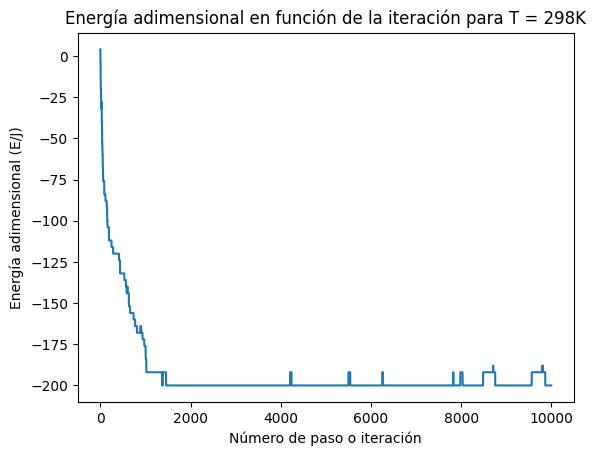

In [5]:
"""
Gráficas de la energía en función del paso de la simulación o iteración
"""
T_ambiente = 298 #K
datos_T_ambiente = datos_e_y_m_metropolis(T_ambiente, Tc)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(datos_T_ambiente.index, datos_T_ambiente['e/J'])
ax1.set_title('Energía adimensional en función de la iteración para T = ' + str(T_ambiente) + 'K')
ax1.set_xlabel('Número de paso o iteración')
ax1.set_ylabel('Energía adimensional (E/J)')

In [6]:
"""
Valores promedio de la energía y magnetización para el sistema a T ambiente (298K). Este promedio se tomó a partir de los últimos 5000 datos de energía y magnetización
"""
energia_adimensional_T_ambiente = np.average(datos_T_ambiente['e/J'][-2500:])
magnetizacion_T_ambiente = np.average(datos_T_ambiente['m'][-2500:])
print('Energía (E/J) a T = ' + str(T_ambiente) + 'K = ' + str(energia_adimensional_T_ambiente))
print('Magnetización a T = ' + str(T_ambiente) + 'K = ' + str(magnetizacion_T_ambiente))

Energía (E/J) a T = 298K = -197.9552
Magnetización a T = 298K = 0.994776


Text(0, 0.5, 'Energía adimensional (E/J)')

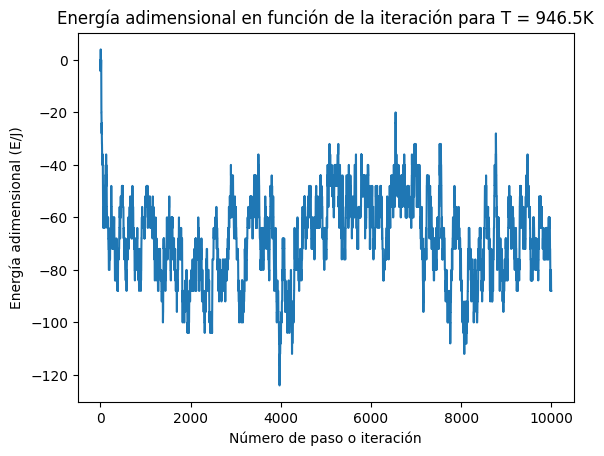

In [7]:
T_2 = 1.5*Tc #K
datos_T_2 = datos_e_y_m_metropolis(T_2, Tc)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(datos_T_2.index, datos_T_2['e/J'])
ax1.set_title('Energía adimensional en función de la iteración para T = ' + str(T_2) + 'K')
ax1.set_xlabel('Número de paso o iteración')
ax1.set_ylabel('Energía adimensional (E/J)')


In [8]:
"""
Valores promedio de la energía y magnetización para el sistema a una temperatura encima de la crítica T = 1.5*Tc. Este promedio se tomó a partir de los últimos 5000 datos de energía y magnetización
"""
energia_adimensional_T_2 = np.average(datos_T_2['e/J'][-2500:])
magnetizacion_T_2 = np.average(datos_T_2['m'][-2500:])
print('Energía (E/J) a T = ' + str(T_2) + 'K = ' + str(energia_adimensional_T_2))
print('Magnetización a T = ' + str(T_2) + 'K = ' + str(magnetizacion_T_2))

Energía (E/J) a T = 946.5K = -72.3712
Magnetización a T = 946.5K = 0.034288000000000006


Text(0, 0.5, 'megnetización')

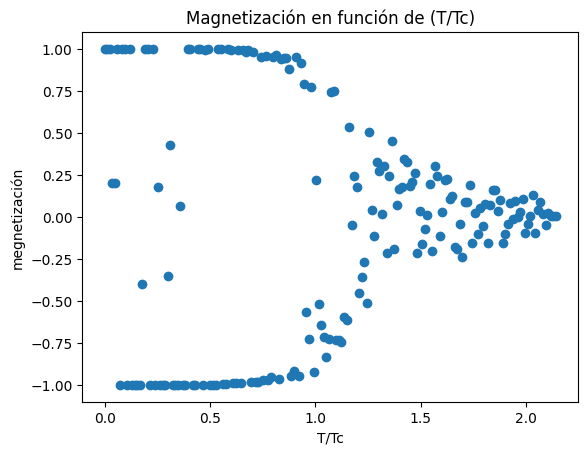

In [9]:
N_puntos = 180
T_span = np.linspace(0.01, 1350, N_puntos) #K 1350K es una temperatura cercana a la de fusión para el Niquel
magnetizacion = np.zeros(N_puntos)
T_adim = (1/Tc)*T_span
for i in range(N_puntos):
    datos_T = datos_e_y_m_metropolis(T_span[i], Tc)
    magnetizacion[i] = np.average(datos_T['m'][-2500:])
#fin for
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(T_adim, magnetizacion)
ax2.set_title("Magnetización en función de (T/Tc)")
ax2.set_xlabel("T/Tc")
ax2.set_ylabel("megnetización")
